<a href="https://colab.research.google.com/github/Wesrsant/projetoaplicadomackenzie_III/blob/main/Projeto_Aplicado_III_Etapa_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Projeto Aplicado III - Etapa 4

In [ ]:
# Importação das bibliotecas

import pandas as pd
import io
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# Carregando o dataframe das avaliações dos livros

df_book_ratings = pd.read_csv('BX-Book-Ratings.csv',sep=';', encoding='latin-1')
df_books = pd.read_csv('BX_Books.csv', sep=';', encoding='latin-1')

In [ ]:
# Removendo notas zero (conforme etapa de Análise Exploratória de Dados***)

df_book_ratings = df_book_ratings[df_book_ratings['Book-Rating'] > 0].copy()

In [ ]:
# Filtrar usuários com mínimo de 3 avaliações

user_counts = df_book_ratings['User-ID'].value_counts()
min_user_ratings = 3
usuarios_ativos = user_counts[user_counts >= min_user_ratings].index
filtro_usuarios_ativos = df_book_ratings['User-ID'].isin(usuarios_ativos)
df_br_filtrado = df_book_ratings[filtro_usuarios_ativos].copy()

In [ ]:
# Filtrar livros com menos de 10 avaliações

book_counts = df_br_filtrado['ISBN'].value_counts()
min_book_ratings = 10
livros_populares = book_counts[book_counts >= min_book_ratings].index
filtro_livros_populares = df_br_filtrado['ISBN'].isin(livros_populares)
df_br_filtrado = df_br_filtrado[filtro_livros_populares].copy()

In [ ]:
df_book_ratings.info() # Quantidade de linhas do dataset após remoção de notas zero: 433671
print(df_book_ratings['ISBN'].nunique()) # Quantidade de livros do dataset após remoção de notas zero
print(df_book_ratings['User-ID'].nunique()) # Quantidade de usuários do dataset após remoção de notas zero

<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB
185973
77805


In [ ]:
df_br_filtrado.info() # Quantidade de linhas após a filtragem de mínimo de avaliações: 110016
print(df_br_filtrado['ISBN'].nunique()) # Quantidade de livros da base filtrada
print(df_br_filtrado['User-ID'].nunique()) # Quantidade de usuários da base filtrada

<class 'pandas.core.frame.DataFrame'>
Index: 110016 entries, 16 to 1149771
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      110016 non-null  int64 
 1   ISBN         110016 non-null  object
 2   Book-Rating  110016 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
4585
17424


In [ ]:
# Criando a matriz de usuário-item (atenção c/ performance e memória RAM)

rating_matrix = df_br_filtrado.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
rating_matrix_sparse = csr_matrix(rating_matrix.values)


In [ ]:
# Exportando matriz para CSV
rating_matrix.to_csv('rating_matrix.csv')

In [ ]:
print(rating_matrix_sparse.shape) # Linhas e colunas da matriz esparsa

(17424, 4585)


In [ ]:
# Aplicando o algoritmo KNN com 30 vizinhos próximos

knn_model = NearestNeighbors(metric='cosine', n_neighbors=30)
knn_model.fit(rating_matrix_sparse)

NearestNeighbors(metric='cosine', n_neighbors=30)

In [ ]:
# FUNÇÃO GERAR RECOMENDAÇÕES POR ID
# Criando uma função para buscar recomendações de livros com base no ID do usuário

def gerar_recomendacoes_por_id(df_br_filtrado, rating_matrix, rating_matrix_sparse, knn_model, user_id, n_neighbors=31, n_recomendacoes=10):

    # Verificando se o user_id é válido para nossa matriz
    if user_id not in rating_matrix.index:
        return "Usuário não encontrado :("

    # Encontrar a posição do usuário na matriz
    index_usuario = rating_matrix.index.get_loc(user_id)

    # Extraindo a linha completa de avaliações do usuário de acordo com user_id
    avaliacoes_usuario = rating_matrix_sparse[index_usuario]

    # Encontrar os vizinhos mais proximos (30 vizinhos)
    distancias, indices = knn_model.kneighbors(avaliacoes_usuario, n_neighbors)

    # Obter os IDs dos usuários vizinhos (excluindo o próprio usuário)
    lista_indices = indices.flatten()
    ids_vizinhos = rating_matrix.index[lista_indices][1:]

    # Coletar os livros avaliados pelos vizinhos
    filtro_vizinhos = df_br_filtrado['User-ID'].isin(ids_vizinhos)
    livros_vizinhos = set(df_br_filtrado[filtro_vizinhos]['ISBN'].unique())

    # Remover livros que o usuário já avaliou
    filtro_usuario = df_br_filtrado['User-ID'] == user_id
    livros_lidos = set(df_br_filtrado[filtro_usuario]['ISBN'].unique())

    # Obtendo o conjunto de livros vizinhos excetuando os livros já avaliados pelo próprio usuário
    livros_vizinhos_unicos = livros_vizinhos - livros_lidos

    # Gerando um dataframe apenas com as avaliações feitas pelos vizinhos
    df_avaliacoes_vizinhos = df_br_filtrado[filtro_vizinhos]

    # Gerando um dataframe com contagem e média
    df_ranking = df_avaliacoes_vizinhos[df_avaliacoes_vizinhos['ISBN'].isin(livros_vizinhos_unicos)].copy()
    contagem_e_media = df_ranking.groupby('ISBN')['Book-Rating'].agg(['count', 'mean']).reset_index()

    # Extraindo um dataframe apenas com os N livros recomendados
    livros_recomendados = contagem_e_media.sort_values(by=['mean', 'count'], ascending=[False, False]).head(n_recomendacoes)

    # Criando um merge dos livros recomendados com o dataframe df_books
    livros_recomendados_pareados = pd.merge(livros_recomendados, df_books, on='ISBN')

    # Verificando se há livros recomendados em número suficiente para atender o número de recomendações
    # Se não, irá gerar o número máximo de livros que possui entre os recomendados
    if (len(livros_recomendados_pareados) < n_recomendacoes):
        n_recomendacoes = len(livros_recomendados_pareados)

    # Clicando um laço para printar as recomendações de livros para o usuário
    print("--------------------------------------------------------")
    print("Veja seus livros recomendados:")
    print("--------------------------------------------------------")
    for i in range(n_recomendacoes):
        print(f"{i+1}. ''{livros_recomendados_pareados.iloc[i]['Book-Title']}'' - {livros_recomendados_pareados.iloc[i]['Book-Author']} - Editora: {livros_recomendados_pareados.iloc[i]['Publisher']}")
    print("--------------------------------------------------------")

In [ ]:
# EXECUTANDO FUNÇÃO GERAR RECOMENDAÇÕES POR ID

# Executando a função para gerar recomendações de acordo com o usuário de id específico
# exemplos: 503, 1184, 3106, 7650, 110497, 164696, 208936, 239535, 269692, 278844

gerar_recomendacoes_por_id(df_br_filtrado, rating_matrix, rating_matrix_sparse, knn_model, 503)

--------------------------------------------------------
Veja seus livros recomendados:
--------------------------------------------------------
1. ''Notes from a Small Island'' - Bill Bryson - Editora: Perennial
2. ''A Confederacy of Dunces (Evergreen Book)'' - John Kennedy Toole - Editora: Grove Press
3. ''A Man Named Dave: A Story of Triumph and Forgiveness'' - David J. Pelzer - Editora: Plume Books
4. ''The Lovely Bones: A Novel'' - Alice Sebold - Editora: Little, Brown
5. ''A Heartbreaking Work of Staggering Genius'' - Dave Eggers - Editora: Vintage Books USA
6. ''Bel Canto: A Novel'' - Ann Patchett - Editora: Perennial
7. ''Paris to the Moon'' - Adam Gopnik - Editora: Random House Trade
8. ''Evening Class'' - Maeve Binchy - Editora: Dell Publishing Company
9. ''A Painted House'' - John Grisham - Editora: Dell Publishing Company
--------------------------------------------------------


In [ ]:
### FUNÇÃO NOVO USUÁRIO ###

def novo_usuario(df_br_filtrado, rating_matrix, knn_model, df_books, n_recomendacoes=10):

    # A função irá gerar um novo usuário, apresentar uma lista de livros populares,
    # registrar as preferências e gerar recomendações específicas para esse novo usuário.

    # Gerando o id do novo usuário
    novo_user_id = 99999999

    # Determinando número de sugestões
    sugestoes = 500

    # Armazenando em um index os livros mais populares da base
    top_livros = df_br_filtrado['ISBN'].value_counts().head(sugestoes+1).index

    # Transformando o index em um dataframe
    df_top_livros = pd.DataFrame(top_livros, columns=['ISBN'])

    # Fazendo um merge com a base de livros
    df_top_pareados = pd.merge(df_top_livros, df_books, on='ISBN')

    # Printando o título e o autor dos livros mais populares do dataset
    print("Lista de livros:")
    print("--------------------------------------------------------")
    for i in range(len(df_top_pareados)):
        print(f"{i+1}. ''{df_top_pareados.iloc[i]['Book-Title']}'' - {df_top_pareados.iloc[i]['Book-Author']}")

    # Gerando uma lista vazia com os livros escolhidos
    livros_escolhidos = []

    # Printando as instruções na tela.
    print("\n--------------------------------------------------------")
    print("\nEstamos criando um novo perfil de usuário.")
    print("Nesse momento, solicitamos por favor os seus três livros favoritos da lista acima.\n")
    print("--------------------------------------------------------")
    print("\nInsira por favor o número dos três livros: (digite 0 para sair)")

    # Recebendo o input dos números referentes aos livros escolhidos
    while(len(livros_escolhidos)<3):
        # o try impede letras, numeros decimais etc.
        try:
            numero = int(input())
            # o if impede numeros fora do intervalo
            if(1<=numero<=sugestoes):
                livros_escolhidos.append(numero)
                titulo = df_top_pareados.iloc[numero-1]['Book-Title']
                print("Livro escolhido registrado com sucesso! Título: ", titulo)
            elif(numero == 0):
                # se for digitado zero, o programa sairá do laço
                break
            else:
                print("Número inválido! Tente novamente.")
                continue
        except:
            print("Entrada inválida! Tente novamente.")

    # O if abaixo é para garantir que a lista de livros escolhidos tem o tamanho correto
    if (len(livros_escolhidos)==3):

        print("Processando...")

        # Ajustamos os números escolhidos para os índices do dataframe (subtraímos 1 do valor)
        indices_df = [num - 1 for num in livros_escolhidos]

        # Criando um dataframe
        df_livros_escolhidos = df_top_pareados.iloc[indices_df]

        # Extrair os ISBNs dos livros selecionados para uma lista
        isbns_escolhidos = df_livros_escolhidos['ISBN'].tolist()

        # Criar uma lista vazia para guardar as novas avaliações
        lista_novas_avaliacoes = []

        # Criando um dicionário com as novas avaliações para cada ISBN
        for isbn in isbns_escolhidos:
            nova_avaliacao = {
                'User-ID': novo_user_id,
                'ISBN': isbn,
                'Book-Rating': 10
            }
            lista_novas_avaliacoes.append(nova_avaliacao)

        # Transformar a lista de novas avaliações em um dataframe
        df_novas_avaliacoes = pd.DataFrame(lista_novas_avaliacoes)

        # Agora vamos concatenar os dois dataframes (o dataframe original e aquele com as novas avaliações)
        df_br_atualizado = pd.concat([df_br_filtrado, df_novas_avaliacoes], ignore_index=True)

        # Atualizando a rating_matrix
        rating_matrix_atualizada = df_br_atualizado.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)
        rating_matrix_sparse_atualizada = csr_matrix(rating_matrix_atualizada.values)

        # Treinando o modelo com o novo usuário
        knn_model_novo = NearestNeighbors(metric='cosine', n_neighbors=31)
        knn_model_novo.fit(rating_matrix_sparse_atualizada)

        print("\n")
        # Agora chamando a função para gerar recomendações com id passando o id do novo usuário que acabamos de criar
        gerar_recomendacoes_por_id(df_br_atualizado, rating_matrix_atualizada, rating_matrix_sparse_atualizada, knn_model_novo, novo_user_id, n_neighbors=31,n_recomendacoes=10)

    # Caso o operador tenha escolhido a opção zero, o programa termina
    else:
        print("Até mais ;)")

In [ ]:
# EXECUTANDO FUNÇÃO DE NOVO USUÁRIO

novo_usuario(df_br_filtrado, rating_matrix, knn_model, df_books, 10)

Lista de livros:
--------------------------------------------------------
1. ''The Lovely Bones: A Novel'' - Alice Sebold
2. ''The Da Vinci Code'' - Dan Brown
3. ''Wild Animus'' - Rich Shapero
4. ''The Red Tent (Bestselling Backlist)'' - Anita Diamant
5. ''Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))'' - J. K. Rowling
6. ''Divine Secrets of the Ya-Ya Sisterhood: A Novel'' - Rebecca Wells
7. ''The Secret Life of Bees'' - Sue Monk Kidd
8. ''Angels & Demons'' - Dan Brown
9. ''Where the Heart Is (Oprah's Book Club (Paperback))'' - Billie Letts
10. ''Girl with a Pearl Earring'' - Tracy Chevalier
11. ''The Pilot's Wife : A Novel'' - Anita Shreve
12. ''Interview with the Vampire'' - Anne Rice
13. ''A Painted House'' - John Grisham
14. ''Snow Falling on Cedars'' - David Guterson
15. ''The Five People You Meet in Heaven'' - Mitch Albom
16. ''Good in Bed'' - Jennifer Weiner
17. ''Life of Pi'' - Yann Martel
18. ''The Catcher in the Rye'' - J.D. Salinger
19. ''Harry Potter and 

In [ ]:
# FUNÇÃO NÚMERO DE RECOMENDAÇÕES POR ID
# Função que retorna com o número de livros recomendados para o id solicitado

def numero_recomendacoes_por_id(df_br_filtrado, rating_matrix, rating_matrix_sparse, n_neighbors, user_id):

    # Verificando se o user_id é válido para nossa matriz
    if user_id not in rating_matrix.index:
        return "Usuário não encontrado :("

    # Encontrar a posição do usuário na matriz
    index_usuario = rating_matrix.index.get_loc(user_id)

    # Extraindo a linha completa de avaliações do usuário de acordo com user_id
    avaliacoes_usuario = rating_matrix_sparse[index_usuario]

    # Encontrar os vizinhos mais proximos (n_neighbors vizinhos)
    distancias, indices = knn_model.kneighbors(avaliacoes_usuario, n_neighbors+1)

    # Obter os IDs dos usuários vizinhos (excluindo o próprio usuário)
    lista_indices = indices.flatten()
    ids_vizinhos = rating_matrix.index[lista_indices][1:]

    # Coletar os livros avaliados pelos vizinhos
    filtro_vizinhos = df_br_filtrado['User-ID'].isin(ids_vizinhos)
    livros_vizinhos = set(df_br_filtrado[filtro_vizinhos]['ISBN'].unique())

    # Remover livros que o usuário já avaliou
    filtro_usuario = df_br_filtrado['User-ID'] == user_id
    livros_lidos = set(df_br_filtrado[filtro_usuario]['ISBN'].unique())

    # Obtendo o conjunto de livros vizinhos excetuando os livros já avaliados pelo próprio usuário
    livros_vizinhos_unicos = livros_vizinhos - livros_lidos

    # Gerando um dataframe apenas com as avaliações feitas pelos vizinhos
    df_avaliacoes_vizinhos = df_br_filtrado[filtro_vizinhos]

    # Gerando um dataframe com contagem e média
    df_ranking = df_avaliacoes_vizinhos[df_avaliacoes_vizinhos['ISBN'].isin(livros_vizinhos_unicos)].copy()
    contagem_e_media = df_ranking.groupby('ISBN')['Book-Rating'].agg(['count', 'mean']).reset_index()

    # Extraindo um dataframe apenas com os N livros recomendados
    livros_recomendados = contagem_e_media.sort_values(by=['mean', 'count'], ascending=[False, False])

    # Criando um merge dos livros recomendados com o dataframe df_books
    livros_recomendados_pareados = pd.merge(livros_recomendados, df_books, on='ISBN')

    return len(livros_recomendados_pareados)

In [ ]:
# Exemplo: Executando função de número de recomendações por id (n_neighbors = 31, id = 503)
numero_recomendacoes_por_id(df_br_filtrado, rating_matrix, rating_matrix_sparse, 31, 503)

38

In [ ]:
# EXTRAINDO SUBCONJUNTO DE USER-IDS ÚNICOS DO DATAFRAME DF_BR_FILTRADO

# Criando array com todos os ids unicos do dataframe
ids_unicos = df_br_filtrado['User-ID'].unique()
# Determinando número de ids que será selecionado aleatoriamente
n_ids_selecionados = 1000
# Determinando a seed global para garantir reprodutibilidade
np.random.seed(123)
# Criando array com ids aleatoriamente selecionados
ids_selecionados = np.random.choice(ids_unicos, n_ids_selecionados, replace=False)


In [ ]:
# CALCULANDO O NÚMERO DE RECOMENDAÇÔES MÉDIAS POR ID

# determinando n_neighbors
n_neighbors = 50

# criando uma lista vazia
lista_numero_recomendacoes = []

# criando um laço para calcular o número de recomendações individualmente por id
for i in range(len(ids_selecionados)):
    id = ids_selecionados[i]
    numero_recomendacoes = numero_recomendacoes_por_id(df_br_filtrado, rating_matrix, rating_matrix_sparse, n_neighbors+1, id)
    lista_numero_recomendacoes.append(numero_recomendacoes)

# obtendo valor médio, mínimo e máximo da lista
media_recomendacoes = np.mean(lista_numero_recomendacoes)
minimo_recomendacoes = np.min(lista_numero_recomendacoes)
maximo_recomendacoes = np.max(lista_numero_recomendacoes)

# obtendo número de recomendações superior a 10
numero_recomendacoes_maior_ou_igual_a_10 = np.sum(np.array(lista_numero_recomendacoes) >= 10)
porcentagem = numero_recomendacoes_maior_ou_igual_a_10/n_ids_selecionados*100

# printando valores obtidos
print("N_neighbors utilizados para gerar recomendações: ", n_neighbors)
print("Média de recomendações: ", media_recomendacoes)
print("Mínimo de recomendações: ", minimo_recomendacoes)
print("Máximo de recomendações: ", maximo_recomendacoes)
print("Porcentagem de recomendações maior ou igual a 10: ", porcentagem, "%")


N_neighbors utilizados para gerar recomendações:  50
Média de recomendações:  481.669
Mínimo de recomendações:  0
Máximo de recomendações:  2390
Porcentagem de recomendações maior ou igual a 10:  99.3 %


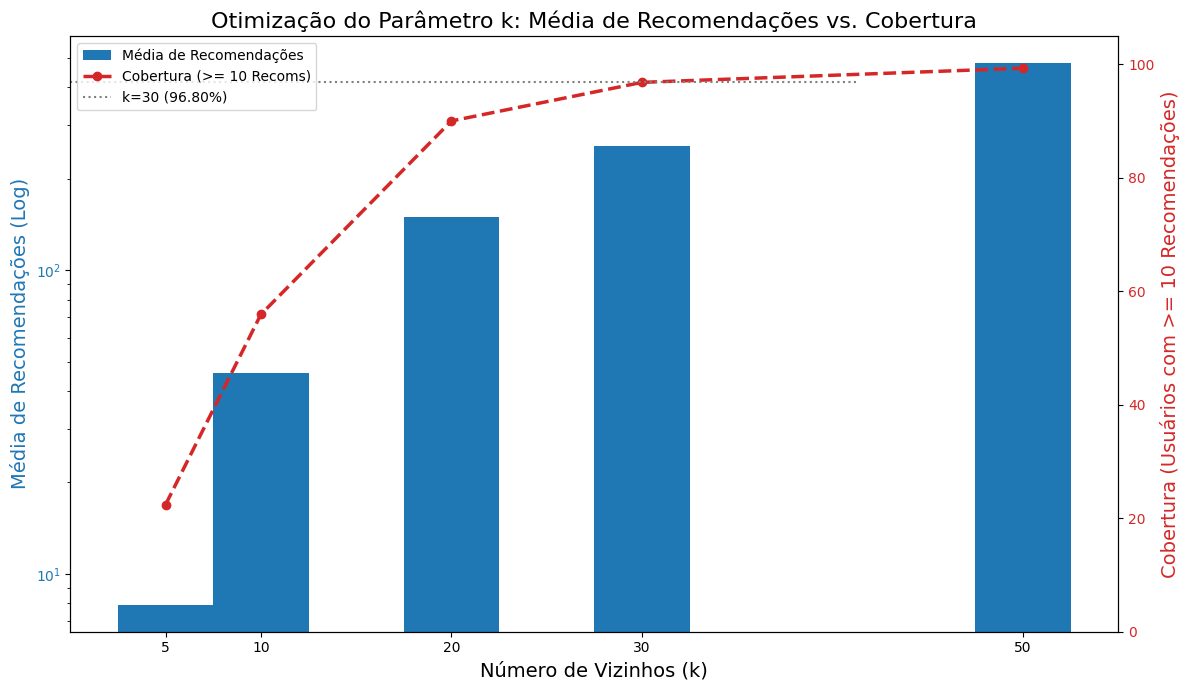

In [ ]:
# VISUALIZAÇÃO DOS DADOS

# 1. Dados da Tabela 1 (Otimização de k)
data = {
    'k': [5, 10, 20, 30, 50],
    'Media_Recomendacoes': [7.91, 45.71, 149.24, 256.48, 481.67],
    'Porcentagem_gte_10': [22.40, 55.90, 90.00, 96.80, 99.30]
}
df_resultados = pd.DataFrame(data)

# 2. Configurações do Gráfico
fig, ax1 = plt.subplots(figsize=(12, 7))

# Cor primária (Barras)
color_bar = 'tab:blue'
ax1.set_xlabel('Número de Vizinhos (k)', fontsize=14)
ax1.set_ylabel('Média de Recomendações (Log)', color=color_bar, fontsize=14)
# Escala de log na média para melhor visualização
ax1.set_yscale('log')
ax1.bar(df_resultados['k'], df_resultados['Media_Recomendacoes'], color=color_bar, width=5, label='Média de Recomendações')
ax1.tick_params(axis='y', labelcolor=color_bar)
ax1.set_xticks(df_resultados['k'])

# 3. Criar Eixo Y Secundário (Linha)
ax2 = ax1.twinx()  # Instancia um segundo eixo Y que compartilha o mesmo X
color_line = 'tab:red'
ax2.set_ylabel('Cobertura (Usuários com >= 10 Recomendações)', color=color_line, fontsize=14)
ax2.plot(df_resultados['k'], df_resultados['Porcentagem_gte_10'], color=color_line, marker='o', linestyle='--', linewidth=2.5, label='Cobertura (>= 10 Recoms)')
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.set_ylim(0, 105) # Limite de 0 a 105% para a linha
ax2.axhline(y=96.80, color='gray', linestyle=':', xmax=(3/4), label='k=30 (96.80%)') # Linha de referência para k=30

# 4. Título e Legendas
plt.title('Otimização do Parâmetro k: Média de Recomendações vs. Cobertura', fontsize=16)
fig.tight_layout()  # Ajusta o layout
# Adiciona legendas de ambos os eixos
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Salva a figura
plt.savefig('grafico_otimizacao_k.png')

# Exibe o gráfico
plt.show()

--- Dados Simulados (k=30) ---
Média simulada: 47.29 (Alvo era: 256.48)
Mínimo simulado: 0 (Alvo era: 0.0)
Máximo simulado: 2258 (Alvo era: 2258.0)
-----------------------------------
Gerando gráfico com dados simulados...


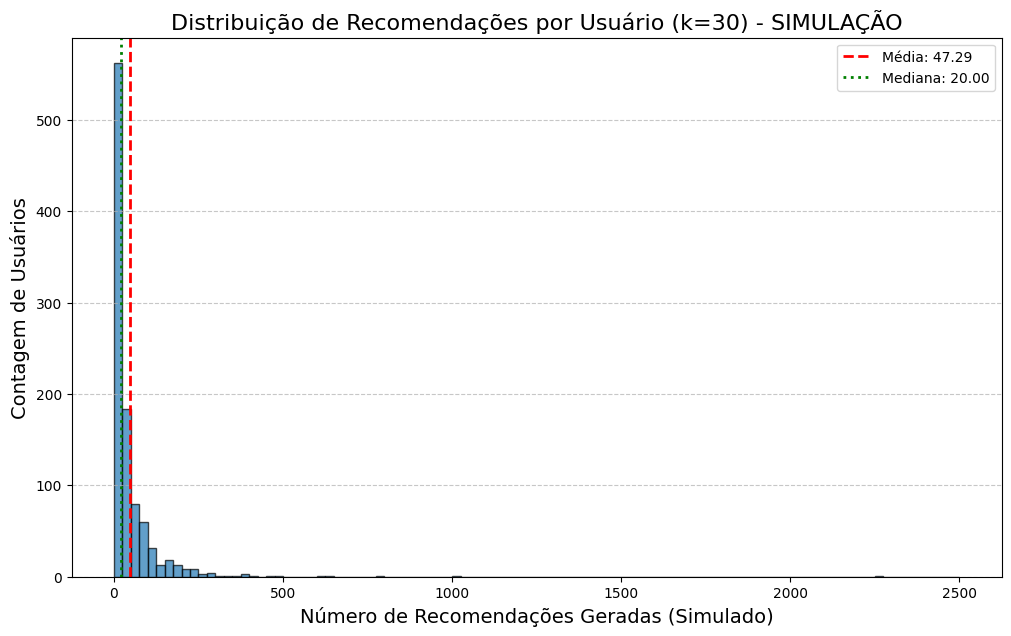

In [ ]:
# --- 1. SIMULAÇÃO DOS DADOS (k=30) ---
np.random.seed(123)

# Parâmetros-alvo (da Tabela 1 para k=30)
n_amostras = 1000
media_alvo = 256.48
max_alvo = 2258.0
min_alvo = 0.0
sigma_simulado = 1.3

dados_base = np.random.lognormal(mean=0.0, sigma=sigma_simulado, size=n_amostras)
dados_ajustados_media = (dados_base / np.mean(dados_base)) * media_alvo
dados_ajustados_max = (dados_ajustados_media / np.max(dados_ajustados_media)) * max_alvo
lista_simulada = np.floor(dados_ajustados_max).astype(int)
lista_simulada[lista_simulada < 0] = 0

print(f"--- Dados Simulados (k=30) ---")
print(f"Média simulada: {np.mean(lista_simulada):.2f} (Alvo era: {media_alvo})")
print(f"Mínimo simulado: {np.min(lista_simulada)} (Alvo era: {min_alvo})")
print(f"Máximo simulado: {np.max(lista_simulada)} (Alvo era: {max_alvo})")
print("-----------------------------------")
print("Gerando gráfico com dados simulados...")

# --- 2. SCRIPT DE VISUALIZAÇÃO (Usa lista para k=30) ---
k_valor = 30

plt.figure(figsize=(12, 7))

# Plotar o histograma dos dados SIMULADOS
plt.hist(lista_simulada, bins=100, range=(0, 2500), edgecolor='black', alpha=0.7)

# Títulos e Legendas
plt.title(f'Distribuição de Recomendações por Usuário (k={k_valor}) - SIMULAÇÃO', fontsize=16)
plt.xlabel('Número de Recomendações Geradas (Simulado)', fontsize=14)
plt.ylabel('Contagem de Usuários', fontsize=14)

# Linhas de Média e Mediana (baseadas nos dados simulados)
media_real_simulada = np.mean(lista_simulada)
mediana_real_simulada = np.median(lista_simulada)

plt.axvline(media_real_simulada, color='red', linestyle='--', linewidth=2, label=f'Média: {media_real_simulada:.2f}')
plt.axvline(mediana_real_simulada, color='green', linestyle=':', linewidth=2, label=f'Mediana: {mediana_real_simulada:.2f}')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f'grafico_distribuicao_k{k_valor}_simulado.png')
plt.show()